In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tqdm import tqdm_notebook
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from pprint import pprint


import seaborn as sns

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Load data and do some pre-processing

In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [3]:
print(f"train shape : {df_train.shape}")
print(f" test shape : {df_test.shape}")

train shape : (7160, 184)
 test shape : (1791, 183)


In [4]:
#資料格式
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7160 entries, 0 to 7159
Columns: 184 entries, ID to class
dtypes: bool(168), float64(6), int64(4), object(6)
memory usage: 2.0+ MB


In [5]:
#取得數值型態的欄位
numeric_data = df_train._get_numeric_data()
numeric_data.columns

Index(['appearedHour', 'appearedMinute', 'terrainType', 'closeToWater',
       'temperature', 'windSpeed', 'pressure', 'population_density', 'urban',
       'suburban',
       ...
       'cooc_143', 'cooc_144', 'cooc_145', 'cooc_146', 'cooc_147', 'cooc_148',
       'cooc_149', 'cooc_150', 'cooc_151', 'class'],
      dtype='object', length=178)

>## Drop NA in numeric data

In [6]:
# 檢查是否有NA，drop掉每個欄位的NA值並劃出其分布，只要有NaN，刪除該觀察值
for i in numeric_data:
    temp = df_train[i].dropna()
    print(f"there are {df_train[i].shape[0] - temp.shape[0]} NaN in {i}")

there are 0 NaN in appearedHour
there are 0 NaN in appearedMinute
there are 0 NaN in terrainType
there are 0 NaN in closeToWater
there are 0 NaN in temperature
there are 0 NaN in windSpeed
there are 0 NaN in pressure
there are 0 NaN in population_density
there are 0 NaN in urban
there are 0 NaN in suburban
there are 0 NaN in midurban
there are 0 NaN in rural
there are 0 NaN in gymDistanceKm
there are 0 NaN in gymIn100m
there are 0 NaN in gymIn250m
there are 0 NaN in gymIn500m
there are 0 NaN in gymIn1000m
there are 0 NaN in gymIn2500m
there are 0 NaN in gymIn5000m
there are 0 NaN in pokestopDistanceKm
there are 0 NaN in pokestopIn100m
there are 0 NaN in pokestopIn250m
there are 0 NaN in pokestopIn500m
there are 0 NaN in pokestopIn1000m
there are 0 NaN in pokestopIn2500m
there are 0 NaN in pokestopIn5000m
there are 0 NaN in cooc_1
there are 0 NaN in cooc_2
there are 0 NaN in cooc_3
there are 0 NaN in cooc_4
there are 0 NaN in cooc_5
there are 0 NaN in cooc_6
there are 0 NaN in cooc_7
th

In [7]:

# Drop Null Feature(s):  刪除不是 Feature 的欄位
df_all = pd.concat( [ df_train.drop( [ 'ID', 'class' ], axis = 1 ),
                      df_test.drop( [ 'id' ], axis = 1 ) ],
                      axis = 0, ignore_index = False )

In [8]:
# check null status
print( df_all.shape )
#exclude =  'object' 的目的是，Object type的情況下，NA很有可能只是代表沒有，而不是有遺失值，所以在做分析前一定要看資料描述
#isnull():  Detect missing values (NaN in numeric arrays, None/NaN in object arrays)
df_na = df_all.select_dtypes( exclude = [ 'object' ] ).isnull().sum()
if df_na.sum() == 0:
    print('There are no NA data in dataframe')

(8951, 182)
There are no NA data in dataframe


>## One-Hot Encoding

In [9]:
# check bool type data
df_all.select_dtypes('bool')

,closeToWater,urban,suburban,midurban,rural,gymIn100m,gymIn250m,gymIn500m,gymIn1000m,gymIn2500m,...,cooc_142,cooc_143,cooc_144,cooc_145,cooc_146,cooc_147,cooc_148,cooc_149,cooc_150,cooc_151
0,False,True,True,True,False,False,False,False,True,True,...,False,False,False,False,False,False,False,False,False,False
1,True,False,False,False,True,False,False,False,True,True,...,False,False,False,False,False,False,False,False,False,False
2,True,False,False,False,True,False,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
3,True,False,False,False,True,False,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
4,True,True,True,True,False,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
5,False,False,True,True,False,False,False,True,True,True,...,False,False,False,False,False,False,False,False,False,False
6,False,True,True,True,False,False,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
7,True,False,False,False,True,False,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
8,False,True,True,True,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
9,True,False,False,False,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False


In [10]:
df_all.select_dtypes('object')

,appearedTimeOfDay,city,continent,weather,weatherIcon
0,evening,Bangkok,Asia,Clear,clear-day
1,night,New_York,America,Clear,clear-night
2,evening,New_York,America,Clear,clear-day
3,morning,Hobart,Australia,Clear,clear-night
4,evening,Los_Angeles,America,PartlyCloudy,partly-cloudy-day
5,afternoon,Kuching,Asia,Clear,clear-day
6,night,Mexico_City,America,Clear,clear-night
7,afternoon,New_York,America,Clear,clear-day
8,night,Chicago,America,PartlyCloudy,partly-cloudy-day
9,afternoon,New_York,America,PartlyCloudy,partly-cloudy-day


In [11]:
# change bool type data to str type
# 讓使用 get.dummies() 的時候會將其視為 object type， 以方便做 one hot encoding
column_name = df_all.select_dtypes('bool').columns
df_all[column_name] = df_all[column_name].astype( str )
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8951 entries, 0 to 1790
Columns: 182 entries, appearedTimeOfDay to cooc_151
dtypes: float64(6), int64(3), object(173)
memory usage: 12.5+ MB


In [12]:
# pd.get_dummies(): Convert categorical variable into dummy/indicator variables 
#，系統會判定type = object的資料為 categorical variable
df_all_dum = pd.get_dummies(df_all); df_all_dum.head()

,appearedHour,appearedMinute,terrainType,temperature,windSpeed,pressure,population_density,gymDistanceKm,pokestopDistanceKm,appearedTimeOfDay_afternoon,...,cooc_145_False,cooc_146_False,cooc_147_False,cooc_147_True,cooc_148_False,cooc_148_True,cooc_149_False,cooc_149_True,cooc_150_False,cooc_151_False
0,19,10,13,27.8,9.00,1008.96,6019.04440,0.523759,0.144120,0,...,1,1,1,0,1,0,1,0,1,1
1,5,19,13,26.1,8.70,1018.96,0.00000,0.565267,0.198728,0,...,1,1,1,0,1,0,1,0,1,1
2,19,46,0,24.7,16.82,1023.22,0.00000,0.195366,0.070373,0,...,1,1,1,0,1,0,1,0,1,1
3,11,10,0,12.7,13.25,1014.19,128.89505,0.190119,0.003920,0,...,1,1,1,0,1,0,1,0,1,1
4,18,32,13,19.1,5.78,1011.36,4188.39100,0.066120,0.071638,0,...,1,1,1,0,1,0,1,0,1,1


In [13]:
# View all column names
#list(df_all_dum.columns.values)
#list(df_all_dum)

>## Check missing data 

In [14]:
total = df_all_dum.isnull().sum().sort_values(ascending=False)
percent = (df_all_dum.isnull().sum()/df_all_dum.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

missingtype = missing_data.index
missingtype = missingtype.tolist()
missingtype = df_all_dum[missingtype].dtypes
missingtype = missingtype.rename(columns = 'missingtype')
missingtype = pd.DataFrame(missingtype)
missing_data = pd.concat([missing_data, missingtype], axis=1)
missing_data.columns = ['Total', 'Percent','Type']

missing_data.head(20)

,Total,Percent,Type
cooc_151_False,0,0.0,uint8
gymIn5000m_False,0,0.0,uint8
rural_True,0,0.0,uint8
gymIn100m_False,0,0.0,uint8
gymIn100m_True,0,0.0,uint8
gymIn250m_False,0,0.0,uint8
gymIn250m_True,0,0.0,uint8
gymIn500m_False,0,0.0,uint8
gymIn500m_True,0,0.0,uint8
gymIn1000m_False,0,0.0,uint8


In [15]:
print(" One-Hot Encoding 後的 features 數量:",df_all_dum.shape)

 One-Hot Encoding 後的 features 數量: (8951, 441)


In [16]:
###################### 不知道跑 DNN 之前要不要做標準化##############################

## Training Start

In [17]:
X = df_all_dum[:df_train.shape[0]]
#####################################
#用 min max normolization 之後結果更爛
# X = (X-X.min())/(X.max()-X.min())
#########################
pokemonclass = df_train['class']

label_ls = []
for label in tqdm_notebook(pokemonclass):
    onehot = np.zeros(6)  
    onehot[label] = 1
    label_ls.append(onehot)
        
y = np.array(label_ls)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.1, stratify = pokemonclass)

X_test = df_all_dum[ df_train.shape[0]: ]

In [18]:
print('size of training data:', X_train.shape, y_train.shape)
print('size of testing data:', X_val.shape, y_val.shape)

size of training data: (6444, 441) (6444, 6)
size of testing data: (716, 441) (716, 6)


In [57]:
tf.reset_default_graph()

with tf.name_scope('placeholder'):
    input_data = tf.placeholder(tf.float32, shape=[None, 441], name='X')
    y_true = tf.placeholder(tf.float32, shape=[None, 6], name='y')
    
with tf.variable_scope('network'):
    h1 = tf.layers.dense(input_data, 180, activation=tf.nn.relu, name='hidden1') 
    h2 = tf.layers.dense(h1, 90, activation=tf.nn.relu, name='hidden2') 
    #h3 = tf.layers.dense(h2, 75, activation=tf.nn.relu, name='hidden3')
    out = tf.layers.dense(h2, 6, name='output')
    
with tf.name_scope('loss'):
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_true, logits=out), name='loss')
    
with tf.name_scope('accuracy'):
    correct_prediction = tf.equal(tf.argmax(tf.nn.softmax(out), 1), tf.argmax(y_true, 1))
    compute_acc = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
with tf.name_scope('opt'):
    update = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)

    
saver = tf.train.Saver()
    
init = tf.global_variables_initializer()

In [58]:
pprint(tf.global_variables())

[<tf.Variable 'network/hidden1/kernel:0' shape=(441, 180) dtype=float32_ref>,
 <tf.Variable 'network/hidden1/bias:0' shape=(180,) dtype=float32_ref>,
 <tf.Variable 'network/hidden2/kernel:0' shape=(180, 90) dtype=float32_ref>,
 <tf.Variable 'network/hidden2/bias:0' shape=(90,) dtype=float32_ref>,
 <tf.Variable 'network/output/kernel:0' shape=(90, 6) dtype=float32_ref>,
 <tf.Variable 'network/output/bias:0' shape=(6,) dtype=float32_ref>,
 <tf.Variable 'opt/beta1_power:0' shape=() dtype=float32_ref>,
 <tf.Variable 'opt/beta2_power:0' shape=() dtype=float32_ref>,
 <tf.Variable 'network/hidden1/kernel/Adam:0' shape=(441, 180) dtype=float32_ref>,
 <tf.Variable 'network/hidden1/kernel/Adam_1:0' shape=(441, 180) dtype=float32_ref>,
 <tf.Variable 'network/hidden1/bias/Adam:0' shape=(180,) dtype=float32_ref>,
 <tf.Variable 'network/hidden1/bias/Adam_1:0' shape=(180,) dtype=float32_ref>,
 <tf.Variable 'network/hidden2/kernel/Adam:0' shape=(180, 90) dtype=float32_ref>,
 <tf.Variable 'network/hidd

In [59]:
epoch = 1500
bs = 100

train_loss_epoch, train_acc_epoch = [], []
test_loss_epoch, test_acc_epoch = [], []

sess = tf.Session()
sess.run(init)

best_loss = 100.
patience = 300
count = 0

for i in tqdm_notebook(range(epoch)):
    
#     training part
    train_loss_batch, train_acc_batch = [], []
    
    total_batch = len(X_train) // bs
    
    for j in range(total_batch):
        
        X_batch = X_train[j*bs : (j+1)*bs]
        y_batch = y_train[j*bs : (j+1)*bs]
        batch_loss, batch_acc, _ = sess.run([loss, compute_acc, update], 
                                            feed_dict={input_data: X_batch, y_true: y_batch})
        
        train_loss_batch.append(batch_loss)
        train_acc_batch.append(batch_acc)
        
    train_loss_epoch.append(np.mean(train_loss_batch))
    train_acc_epoch.append(np.mean(train_acc_batch))
    
#     testing part
    batch_loss, batch_acc = sess.run([loss, compute_acc], 
                                     feed_dict={input_data: X_val, y_true: y_val})

    test_loss_epoch.append(batch_loss)
    test_acc_epoch.append(batch_acc)
    
    X_train, y_train = shuffle(X_train, y_train)
    
    if i%5 == 0:
        print('step: {:2d}, train loss: {:.3f}, train acc: {:.3f}, test loss: {:.3f}, test acc: {:.3f}'
             .format(i, train_loss_epoch[i], train_acc_epoch[i], test_loss_epoch[i], test_acc_epoch[i]))
# Early stopping        
    if batch_loss < best_loss:
        best_loss = batch_loss
        # 如果是 best loss 就把模型儲存起來
        saver.save(sess, './cd_class/bestweight.ckpt', global_step=i)
        count = 0  
    else:
        count += 1
    
    if count >= patience:
        print("The model didn't improve for {} rounds, break it!".format(patience))
        break

step:  0, train loss: 26.945, train acc: 0.216, test loss: 6.290, test acc: 0.212
step:  5, train loss: 3.976, train acc: 0.303, test loss: 3.888, test acc: 0.383
step: 10, train loss: 3.274, train acc: 0.363, test loss: 2.215, test acc: 0.385
step: 15, train loss: 2.676, train acc: 0.402, test loss: 1.784, test acc: 0.483
step: 20, train loss: 2.393, train acc: 0.448, test loss: 2.000, test acc: 0.436
step: 25, train loss: 2.259, train acc: 0.451, test loss: 1.961, test acc: 0.469
step: 30, train loss: 2.188, train acc: 0.462, test loss: 2.692, test acc: 0.406
step: 35, train loss: 1.952, train acc: 0.498, test loss: 2.677, test acc: 0.440
step: 40, train loss: 1.854, train acc: 0.512, test loss: 1.566, test acc: 0.515
step: 45, train loss: 2.067, train acc: 0.474, test loss: 1.713, test acc: 0.490
step: 50, train loss: 1.637, train acc: 0.522, test loss: 2.176, test acc: 0.444
step: 55, train loss: 1.424, train acc: 0.543, test loss: 1.437, test acc: 0.561
step: 60, train loss: 1.551

In [60]:
#  tf.train.latest_checkpoint 會自動把路徑夏最新一次的結果取出，也可以寫出完整路徑，
#saver.restore(sess, './cd_class/bestweight.ckpt-XX')
saver.restore(sess, tf.train.latest_checkpoint('./cd_class'))  
print(sess.run(loss, feed_dict={input_data: X_val, y_true: y_val}))

INFO:tensorflow:Restoring parameters from ./cd_class/bestweight.ckpt-168
1.1450524


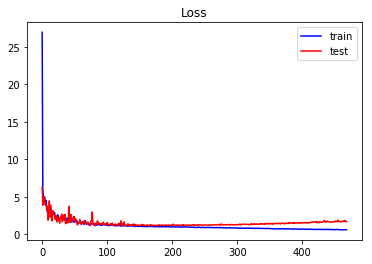

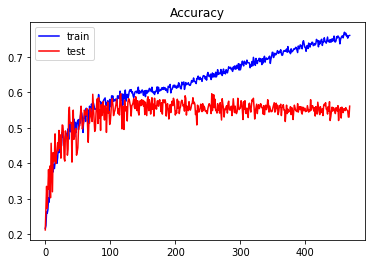

In [61]:
plt.plot(train_loss_epoch, 'b', label='train')
plt.plot(test_loss_epoch, 'r', label='test')
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(train_acc_epoch, 'b', label='train')
plt.plot(test_acc_epoch, 'r', label='test')
plt.legend()
plt.title("Accuracy")
plt.show()

In [62]:
predict = sess.run(tf.argmax(tf.nn.softmax(out), 1), feed_dict={input_data: X_test})
print('predict: ', predict )

predict:  [2 1 4 ... 1 2 4]


In [63]:
sess.close()

In [64]:
predict = pd.DataFrame(predict)

In [65]:
result = pd.concat([df_test['id'], predict[0]], axis=1)

In [66]:
result.columns = ['ID', 'class']

blankIndex=[''] * len(result)
result.index=blankIndex
result

,ID,class
,MTA5MTEwOTYxMzM0NzA2NDEzNzM=,2
,MTY0OTUyMTM2MDExMjg3MjczMjU=,1
,MTQ0ODU1OTEzOTU1NTAyNzI4NjE=,4
,MTY1ODg1MzEwNzYzNDUzMDUwNTM=,3
,MTY0NTg2OTA5MTkzOTE2MTc1MTc=,2
,MTkwNTk1MzkyNzkwNjQ3MDUyNQ==,4
,MTU4NzAwMDQyODIwMTM2MDEyMjk=,2
,ODY5MDY1ODA4Njk5MjAwODI5,4
,MjA2MzcwMzk1Mzg2MTQ0NDMwMQ==,2
,NjcwNDcxODcwMTUxODQxNDE=,4


In [67]:
result.to_csv('submission.csv',index=False)